In [220]:
# Load main packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import getpass # For identifying user/directory structure
import networkx as nx
import re
from sklearn import linear_model
%matplotlib inline

# Load local files
import sys # For reading files in other directories
if(getpass.getuser() == 'rockc_000'):
    sys.path.insert(0, 'C:/Users/rockc_000/Documents/GitHub/GithubSandbox/Python/NCAA Scripts')
    dir = 'C:/Users/rockc_000/Documents/Personal Files/Kaggle/NCAA'
if(getpass.getuser() == 'josh'):
    sys.path.insert(0, '/home/josh/Documents/Github/GithubSandbox/Python/NCAA Scripts')
    dir = '/home/josh/Documents/Personal/Kaggle/NCAA'
from make_submission import make_submission

In [221]:
# Read in data
seasons = pd.read_csv(dir + '/Seasons.csv')
teams = pd.read_csv(dir + '/Teams.csv')
regular_compact_results = pd.read_csv(dir + '/RegularSeasonCompactResults.csv')
regular_detailed_results = pd.read_csv(dir + '/RegularSeasonDetailedResults.csv')
tourney_compact_results = pd.read_csv(dir + '/TourneyCompactResults.csv')
tourney_detailed_results = pd.read_csv(dir + '/TourneyDetailedResults.csv')
tourney_seed = pd.read_csv(dir + '/TourneySeeds.csv')
tourney_slots = pd.read_csv(dir + '/TourneySlots.csv')
sample_submission = pd.read_csv(dir + '/SampleSubmission.csv')

In [222]:
# Look at the first few rows of each dataset, and their dimensions
# sample_submission.iloc[np.arange(5)]
nrow = 4
print('seasons:\n', seasons.head(nrow), '\nDimension: ', seasons.shape)
print('teams:\n', teams.head(nrow), '\nDimension: ', teams.shape)
print('regular_compact_results:\n', regular_compact_results.head(nrow),
      '\nDimension: ', regular_compact_results.shape)
print('regular_detailed_results:\n', regular_detailed_results.head(nrow),
      '\nDimension: ', regular_detailed_results.shape)
print('tourney_compact_results:\n', tourney_compact_results.head(nrow),
      '\nDimension: ', tourney_compact_results.shape)
print('tourney_detailed_results:\n', tourney_detailed_results.head(nrow),
      '\nDimension: ', tourney_detailed_results.shape)
print('tourney_seed:\n', tourney_seed.head(nrow),
      '\nDimension: ', tourney_seed.shape)
print('tourney_slots:\n', tourney_slots.head(nrow),
      '\nDimension: ', tourney_slots.shape)
print('sample_submission:\n', sample_submission.head(nrow),
      '\nDimension: ', sample_submission.shape)

seasons:
    Season     Dayzero Regionw    Regionx    Regiony    Regionz
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West
3    1988  11/02/1987    East    Midwest  Southeast       West 
Dimension:  (32, 6)
teams:
    Team_Id    Team_Name
0     1101  Abilene Chr
1     1102    Air Force
2     1103        Akron
3     1104      Alabama 
Dimension:  (364, 2)
regular_compact_results:
    Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot
0    1985      20   1228      81   1328      64    N      0
1    1985      25   1106      77   1354      70    H      0
2    1985      25   1112      63   1223      56    H      0
3    1985      25   1165      70   1432      54    H      0 
Dimension:  (139920, 8)
regular_detailed_results:
    Season  Daynum  Wteam  Wscore  Lteam  Lscore Wloc  Numot  Wfgm  Wfga ...   \
0    2003      10   1104      68   1328      6

## Pagerank algorithm on historical wins

In [223]:
# Initialize DataFrame with one (meaningless) row
pagerank_score = pd.DataFrame({'Season': [1900], 'Team': [0], 'Score': [0]})
for season in seasons['Season']:
    G = nx.DiGraph()
    edges = regular_compact_results.ix[regular_compact_results['Season'] == season,
                                       ('Wteam', 'Lteam')]
    for row in np.arange(edges.shape[0]):
        G.add_edge(edges.iloc[row][1], edges.iloc[row][0])
    # Calculate the page-rank using the networkx package
    out = nx.pagerank(G)
    # Convert the page-rank scores into a DataFrame.
    out = pd.DataFrame.from_dict(out, orient='index')
    out.rename(columns={0: 'Score'}, inplace=True)
    out['Team'] = out.index
    out['Season'] = season
    pagerank_score = pagerank_score.append(out)
pagerank_score = pagerank_score.ix[pagerank_score['Team'] != 0]

## Aggregated Statistics

In [224]:
win_count = regular_compact_results.groupby(('Season', 'Wteam'))
win_count = win_count['Daynum'].count()

# Aggregate the scores for the winning team and losing team
# as well as the number of games played.
win_pts = regular_compact_results.groupby(('Season', 'Wteam'))
win_pts = pd.merge(win_pts[('Lscore', 'Wscore')].sum(),
                    pd.DataFrame(win_pts['Season'].count()),
                    left_index=True, right_index=True)
lose_pts = regular_compact_results.groupby(('Season', 'Lteam'))
lose_pts = pd.merge(lose_pts[('Lscore', 'Wscore')].sum(),
                    pd.DataFrame(lose_pts['Season'].count()),
                    left_index=True, right_index=True)

win_pts.index.set_names(('Season', 'Team'), inplace=True)
lose_pts.index.set_names(('Season', 'Team'), inplace=True)
lose_pts.rename(columns={'Lscore': 'Points_for', 'Wscore': 'Points_againt',
                         'Season': 'Game_cnt'}, inplace=True)
win_pts.rename(columns={'Wscore': 'Points_for', 'Lscore': 'Points_againt',
                        'Season': 'Game_cnt'}, inplace=True)
total_pts = win_pts.append(lose_pts)
total_pts = total_pts.groupby(level=('Season', 'Team')).sum()

In [225]:
print(total_pts.loc[1985].loc[1102])
print(win_pts.loc[1985].loc[1102])
print(lose_pts.loc[1985].loc[1102])

Game_cnt           24
Points_againt    1653
Points_for       1514
Name: 1102, dtype: int64
Points_againt    305
Points_for       355
Game_cnt           5
Name: 1102, dtype: int64
Points_for       1159
Points_againt    1348
Game_cnt           19
Name: 1102, dtype: int64


In [226]:
#stat_vars = np.array(('or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf'),
#                     dtype=str)
#win_vars = np.array(['W' + x for x in stat_vars])
#lose_vars = np.array(['L' + x for x in stat_vars])

# Add a column to make counting games easier:
regular_detailed_results['all_one'] = 1
detail_win = regular_detailed_results.groupby(('Season', 'Wteam'))
detail_win = detail_win[('Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf',
                         'Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf',
                         'all_one')].sum()
def col_rename(col_name):
    if(re.search('W', col_name) is not None):
        col_name = re.sub('W', '', col_name)
        col_name = col_name + '_for'
    if(re.search('L', col_name) is not None):
        col_name = re.sub('L', '', col_name)
        col_name = col_name + '_against'
    return(col_name)
detail_win.rename(columns=col_rename, inplace=True)
detail_win.index.set_names(('Season', 'Team'), inplace=True)

detail_lose = regular_detailed_results.groupby(('Season', 'Lteam'))
detail_lose = detail_lose[('Lor', 'Ldr', 'Last', 'Lto', 'Lstl', 'Lblk', 'Lpf',
                           'Wor', 'Wdr', 'Wast', 'Wto', 'Wstl', 'Wblk', 'Wpf',
                           'all_one')].sum()
def col_rename(col_name):
    if(re.search('W', col_name) is not None):
        col_name = re.sub('W', '', col_name)
        col_name = col_name + '_against'
    if(re.search('L', col_name) is not None):
        col_name = re.sub('L', '', col_name)
        col_name = col_name + '_for'
    return(col_name)
detail_lose.rename(columns=col_rename, inplace=True)
detail_lose.index.set_names(('Season', 'Team'), inplace=True)

detail_data = detail_win.append(detail_lose)
detail_data = detail_data.groupby(level=('Season', 'Team')).sum()
detail_data.drop(labels='all_one', axis=1, inplace=True)

## Other variables

- It'd be interesting to look at trends.  So, we could fit a linear regression to the point difference over time, and see if they tend to be winning or losing by more and more points.

## Create final DataFrame

In [227]:
# Merge independent variables together
print(detail_data.shape)
print(total_pts.shape)
print(win_count.shape)
final_data = pd.merge(detail_data, total_pts, right_index=True, left_index=True, how='outer')
win_count = pd.DataFrame(win_count)
win_count.index.rename(('Season', 'Team'), inplace=True)
win_count.rename(columns={'Daynum': 'Win_count'}, inplace=True)
final_data = pd.merge(final_data, win_count, right_index=True, left_index=True, how='outer')

(4428, 14)
(9835, 3)
(9821,)


In [228]:
# Rename d to have biggest team/smallest team (by ID) instead of win/lose
d = tourney_compact_results.copy()
d['Larger_id_win'] = d['Wteam'] > d['Lteam']
d['Bteam'] = d.ix[:, ('Wteam', 'Lteam')].max(axis=1)
d['Steam'] = d.ix[:, ('Wteam', 'Lteam')].min(axis=1)
d['Bscore'] = d['Wscore']
d.loc[d['Bteam'] == d['Lteam'], 'Bscore'] = \
    d.loc[d['Bteam'] == d['Lteam'], 'Lscore']
d['Sscore'] = d['Lscore']
d.loc[d['Bteam'] == d['Lteam'], 'Sscore'] = \
    d.loc[d['Bteam'] == d['Lteam'], 'Wscore']
d.drop(['Wteam', 'Lteam', 'Wscore', 'Lscore'], axis=1, inplace=True)
d.head()

,Season,Daynum,Wloc,Numot,Larger_id_win,Bteam,Steam,Bscore,Sscore
0,1985,136,N,0,False,1234,1116,54,63
1,1985,136,N,0,False,1345,1120,58,59
2,1985,136,N,0,False,1250,1207,43,68
3,1985,136,N,0,False,1425,1229,55,58
4,1985,136,N,0,False,1325,1242,38,49


In [229]:
to_merge = final_data.copy()
to_merge.rename(columns=lambda x: 'B_' + x, inplace=True)
d = pd.merge(d, to_merge, left_on=('Season', 'Bteam'), right_index=True)
# Rename the columns to start with S instead of B
to_merge.rename(columns=lambda x: 'S' + x[1:], inplace=True)
d = pd.merge(d, to_merge, left_on=('Season', 'Steam'), right_index=True)
d.head()

,Season,Daynum,Wloc,Numot,Larger_id_win,Bteam,Steam,Bscore,Sscore,B_or_for,...,S_dr_against,S_ast_against,S_to_against,S_stl_against,S_blk_against,S_pf_against,S_Game_cnt,S_Points_againt,S_Points_for,S_Win_count
0,1985,136,N,0,False,1234,1116,54,63,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33,2036,2156,21
39,1985,138,N,0,True,1385,1116,68,65,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33,2036,2156,21
1,1985,136,N,0,False,1345,1120,58,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29,1933,2040,18
53,1985,144,N,0,True,1314,1120,62,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29,1933,2040,18
32,1985,138,N,0,False,1242,1120,64,66,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29,1933,2040,18


## Quick Correlation Plots

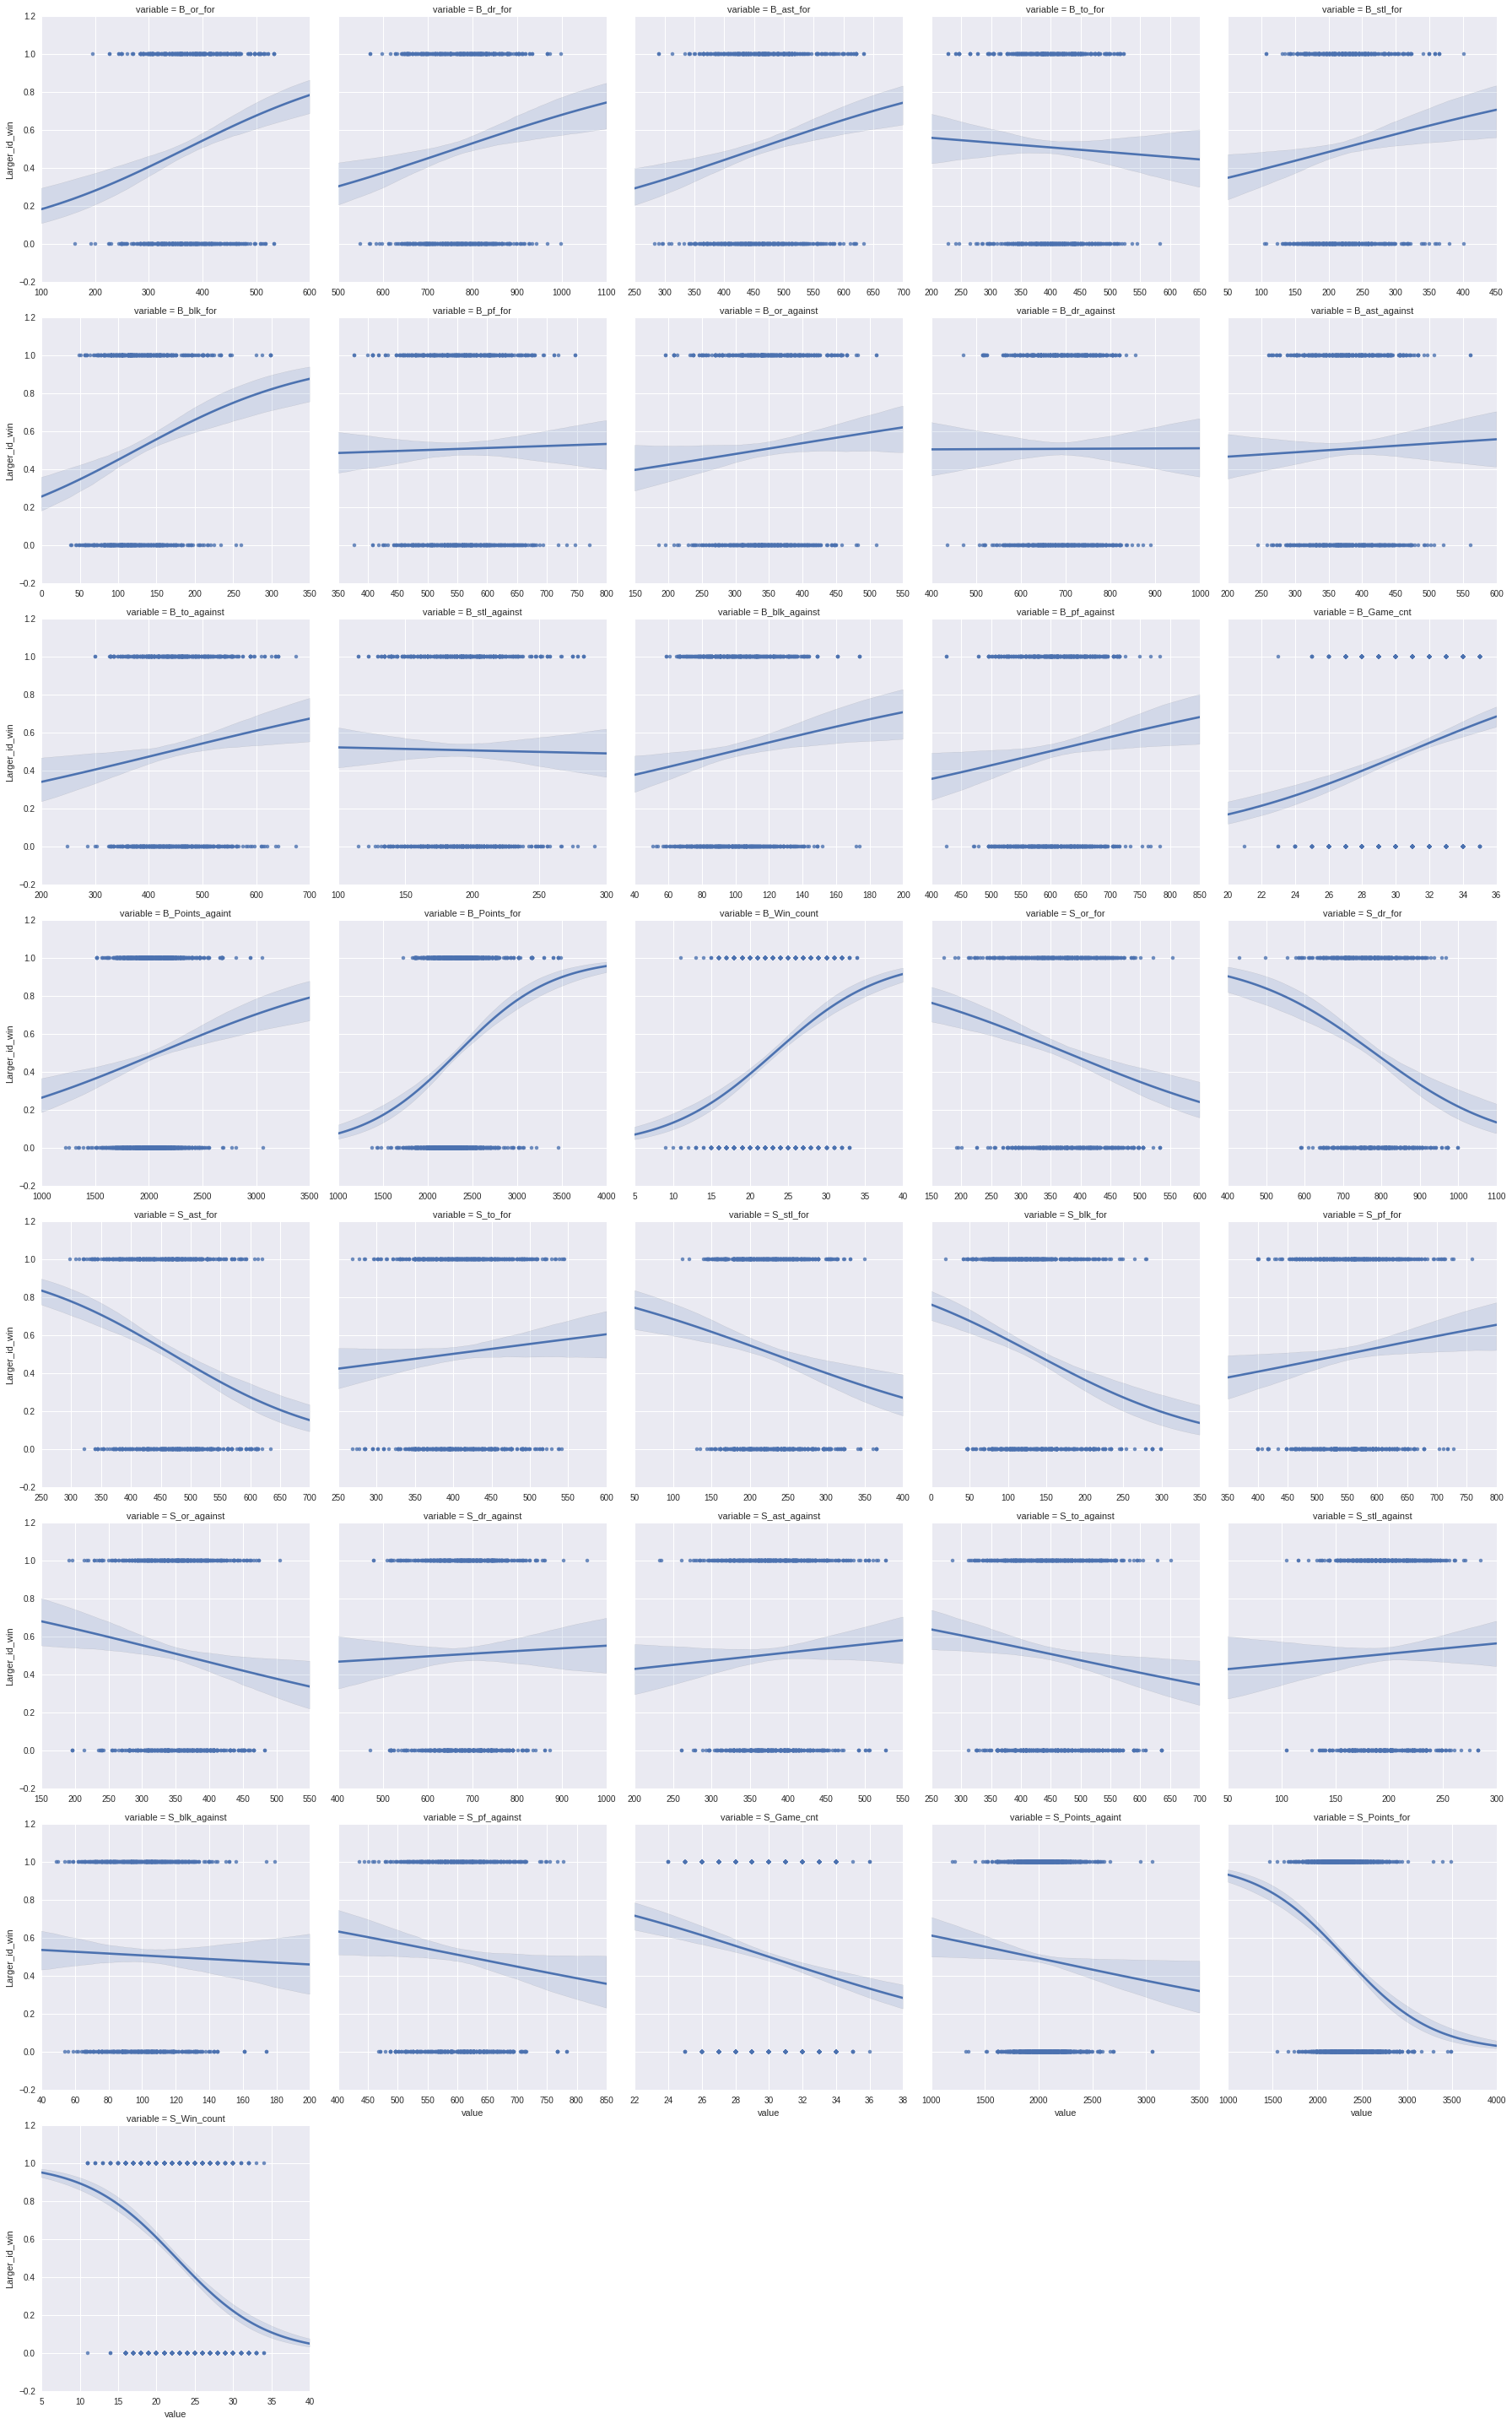

In [230]:
to_plot = pd.melt(d, id_vars='Larger_id_win', value_vars=list(d.columns[9:]))
sns.lmplot(x='value', y='Larger_id_win', data=to_plot,
           col='variable', logistic=True, col_wrap=5,
           sharex=False)

## Adding Ratios

In [231]:
col_filter = [re.match('B_', x) is not None for x in list(d.columns)]
ratio_cols = d.columns[col_filter]
ratio_cols = [re.sub('B_', 'R_', x) for x in ratio_cols]
for col in ratio_cols:
    B_col = re.sub('R_', 'B_', col)
    S_col = re.sub('R_', 'S_', col)
    d[col] = d[B_col] / d[S_col]
d.iloc[:, (d.shape[1]-15):].tail()
#d.loc[1978, :]

,R_to_for,R_stl_for,R_blk_for,R_pf_for,R_or_against,R_dr_against,R_ast_against,R_to_against,R_stl_against,R_blk_against,R_pf_against,R_Game_cnt,R_Points_againt,R_Points_for,R_Win_count
1950,0.755435,1.311377,1.114286,0.887737,0.638436,0.804012,0.639618,1.142450,0.615000,0.771429,0.905785,0.939394,0.733560,0.831443,1.350000
1970,0.879747,0.935897,0.966942,1.064182,0.597561,0.668806,0.618938,1.060847,0.698864,1.421053,0.949740,0.911765,0.774642,0.793284,0.931034
1951,0.743976,0.841530,1.239583,0.838115,0.867220,1.055755,0.888235,1.063492,0.794118,0.837500,1.152256,1.172414,1.017600,1.195695,1.550000
1967,0.651715,0.827957,0.850000,0.669394,0.649068,0.786863,0.764557,0.893333,0.733696,0.752809,1.056897,1.030303,0.814688,0.987475,1.291667
1971,0.573086,0.660944,0.772727,0.606825,0.593750,0.959150,0.707260,0.780886,0.576923,0.471831,0.963836,0.971429,0.796992,0.896223,1.291667
